# Classification of three arrythmia types 

AI in Healthcare project

## Load dependencies and define arrythmia types

Define the arrythmia types I want to have a closer look at.


In [336]:
import pandas as pd
import os
import numpy as np
from enum import Enum
import seaborn as sns
import matplotlib.pyplot as plt
import ast
from scipy import stats, signal
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import shap
from sklearn.multiclass import OneVsRestClassifier
from scipy import stats, signal
import pywt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [2]:
class ArrhythmiaTypes(Enum):
    SB = "SB"
    AFIB = "AFIB"
    SR = "SR"

## Load and prepare the data

In the following step the diagnostic data and the ecg data is combined into a data frame.

In [302]:
diagnostics_file = 'Diagnostics.xlsx'
diagnostics_data = pd.read_excel(diagnostics_file)

# Filter the diagnostics data based on Arrhythmia types in the enum
allowed_rhythms = [arrhythmia.value for arrhythmia in ArrhythmiaTypes]
filtered_diagnostics_data = diagnostics_data[diagnostics_data['Rhythm'].isin(allowed_rhythms)]

combined_data_list = []

ecg_files = os.listdir('ECGData')

# My Laptop is not good enough to handle more files, the code takes forever to run -> you can remove this line if your hardware is better
files_limit = 3000

for i, file_name in enumerate(ecg_files):
    if i >= files_limit:
        break

    ecg_file_path = os.path.join('ECGData', file_name)
    ecg_data = pd.read_csv(ecg_file_path)

    # Find the corresponding row in the filtered diagnostics data
    diagnostics_row = filtered_diagnostics_data[filtered_diagnostics_data['FileName'] == file_name.replace('.csv', '')]

    if not diagnostics_row.empty:
        combined_dict = diagnostics_row.iloc[0].to_dict()

        # Add ECG data to the dictionary
        for col in ecg_data.columns:
            combined_dict[f'ECG_{col}'] = ecg_data[col].tolist()

        combined_data_list.append(combined_dict)

combined_df = pd.DataFrame(combined_data_list)

# Replace empty lists with NaN
combined_df = combined_df.applymap(lambda x: np.nan if isinstance(x, list) and len(x) == 0 else x)

print("Number of patient entries after filtering: ", len(combined_df.index))


Number of patient entries after filtering:  2094


/var/folders/pb/22cxtyzd653c2q7dxd_fy0_r0000gp/T/ipykernel_896/1136770123.py:37: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  combined_df = combined_df.applymap(lambda x: np.nan if isinstance(x, list) and len(x) == 0 else x)


## Data exploration

Before I start the exploration I want to have a look at the percentage of each arrythmia type in the unfiltered dataset to choose the most common arrythmia types.

In [303]:
def analyze_arrhythmia_distribution(diagnostics_file_path):
    df = pd.read_excel(diagnostics_file_path)
    
    # Count the occurrences of each arrhythmia type
    arrhythmia_counts = df['Rhythm'].value_counts()
    
    # Calculate percentages
    total_count = len(df)
    arrhythmia_percentages = (arrhythmia_counts / total_count) * 100
    
    distribution_df = pd.DataFrame({
        'Count': arrhythmia_counts,
        'Percentage': arrhythmia_percentages
    })
    
    print("Arrhythmia Distribution:")
    print(distribution_df)

analyze_arrhythmia_distribution('Diagnostics.xlsx')


Arrhythmia Distribution:
        Count  Percentage
Rhythm                   
SB       3889   36.530152
SR       1826   17.151982
AFIB     1780   16.719895
ST       1568   14.728537
SVT       587    5.513808
AF        445    4.179974
SA        399    3.747887
AT        121    1.136577
AVNRT      16    0.150291
AVRT        8    0.075146
SAAWR       7    0.065752


First I want to have a general overview over the data in the filtered dataset: the gender, age and arrythmia type distribution.

In [304]:
# Visualize Gender Distribution
def visualize_gender():
    plt.figure(figsize=(4, 2))
    sns.countplot(x='Gender', data=filtered_diagnostics_data)
    plt.title('Gender Distribution')
    plt.xlabel('Gender')
    plt.ylabel('Count')
    plt.show()

# Calculate exact numbers
def calc_gender():
    gender_counts = filtered_diagnostics_data['Gender'].value_counts()
    total_counts = combined_df.shape[0]

    print("Number of data sets by gender:")
    print(gender_counts)

In [305]:
# Visualize Age Distribution
def visualize_age():
    plt.figure(figsize=(4, 2))
    sns.histplot(filtered_diagnostics_data['PatientAge'], kde=True, bins=10)
    plt.title('Age Distribution')
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    plt.show()

# Calculate exact numbers
def calc_age_boxplot():
    age = filtered_diagnostics_data['PatientAge']
    min_age = age.min()
    max_age = age.max()
    mean_age = age.mean()
    median_age = age.median()
    std_dev_age = age.std()

    # Create box plot
    plt.figure(figsize=(4, 2))
    ax = sns.boxplot(y=age, color='lightblue')

    plt.axhline(mean_age, color='red', linestyle='--', label=f'Mean: {mean_age:.2f}')
    plt.axhline(median_age, color='green', linestyle='-', label=f'Median: {median_age:.2f}')
    plt.title('Box Plot of Patient Age with Mean and Median')
    plt.ylabel('Age')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    print("Age Statistics:")
    print(f"Minimum Age: {min_age}")
    print(f"Maximum Age: {max_age}")
    print(f"Mean Age: {mean_age:.2f}")
    print(f"Median Age: {median_age}")
    print(f"Standard Deviation of Age: {std_dev_age:.2f}")

In [306]:
# Visualize Arrythmia Distribution
def visualize_arrythmia():
    plt.figure(figsize=(4, 2))
    sns.countplot(x='Rhythm', data=filtered_diagnostics_data)
    plt.title('Arrythmia Types Distribution')
    plt.xlabel('Arrythmia Type')
    plt.ylabel('Count')
    plt.show()

In [307]:
# Visualize gender and age
def visualize_gender_age():
    plt.figure(figsize=(4, 2))
    sns.boxplot(x='Gender', y='PatientAge', data=combined_df)
    plt.title('Age Distribution by Gender')
    plt.xlabel('Gender')
    plt.ylabel('Age')
    plt.show()

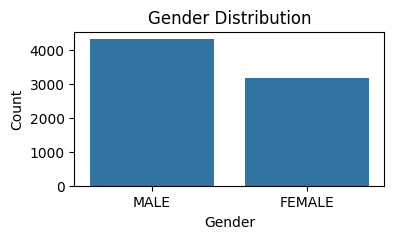

Number of data sets by gender:
Gender
MALE      4324
FEMALE    3171
Name: count, dtype: int64


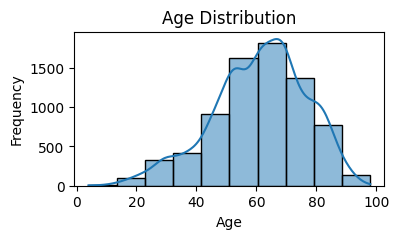

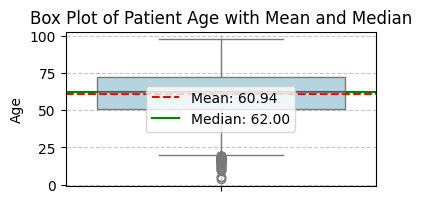

Age Statistics:
Minimum Age: 4
Maximum Age: 98
Mean Age: 60.94
Median Age: 62.0
Standard Deviation of Age: 15.69


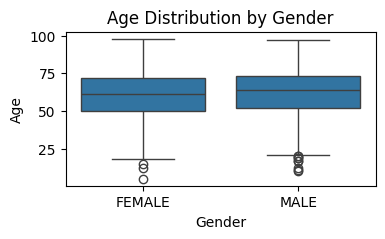

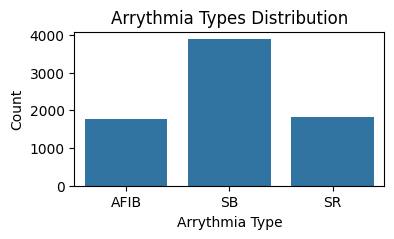

In [308]:
visualize_gender()
calc_gender()
visualize_age()
calc_age_boxplot()
visualize_gender_age()
visualize_arrythmia()

Let's have a look at the numerical data (except the ECG data):

        PatientAge  VentricularRate  AtrialRate  QRSDuration  QTInterval  \
min           5.00            34.00       23.00        60.00      204.00   
max          98.00           198.00      500.00       206.00      736.00   
mean         61.20            69.27       81.30        91.48      406.53   
median       63.00            59.00       59.00        90.00      410.00   
std          15.75            21.64       60.83        15.49       46.93   

        QTCorrected   RAxis   TAxis  QRSCount  QOnset  QOffset  TOffset  
min          269.00  -89.00  -88.00      5.00  176.00   249.00   317.00  
max          643.00  241.00  270.00     33.00  232.00   314.00   582.00  
mean         425.83   36.87   42.06     11.38  219.49   265.23   422.75  
median       422.00   43.00   39.00     10.00  220.00   264.00   424.00  
std           33.92   36.78   51.41      3.56    5.67     7.89    23.69  


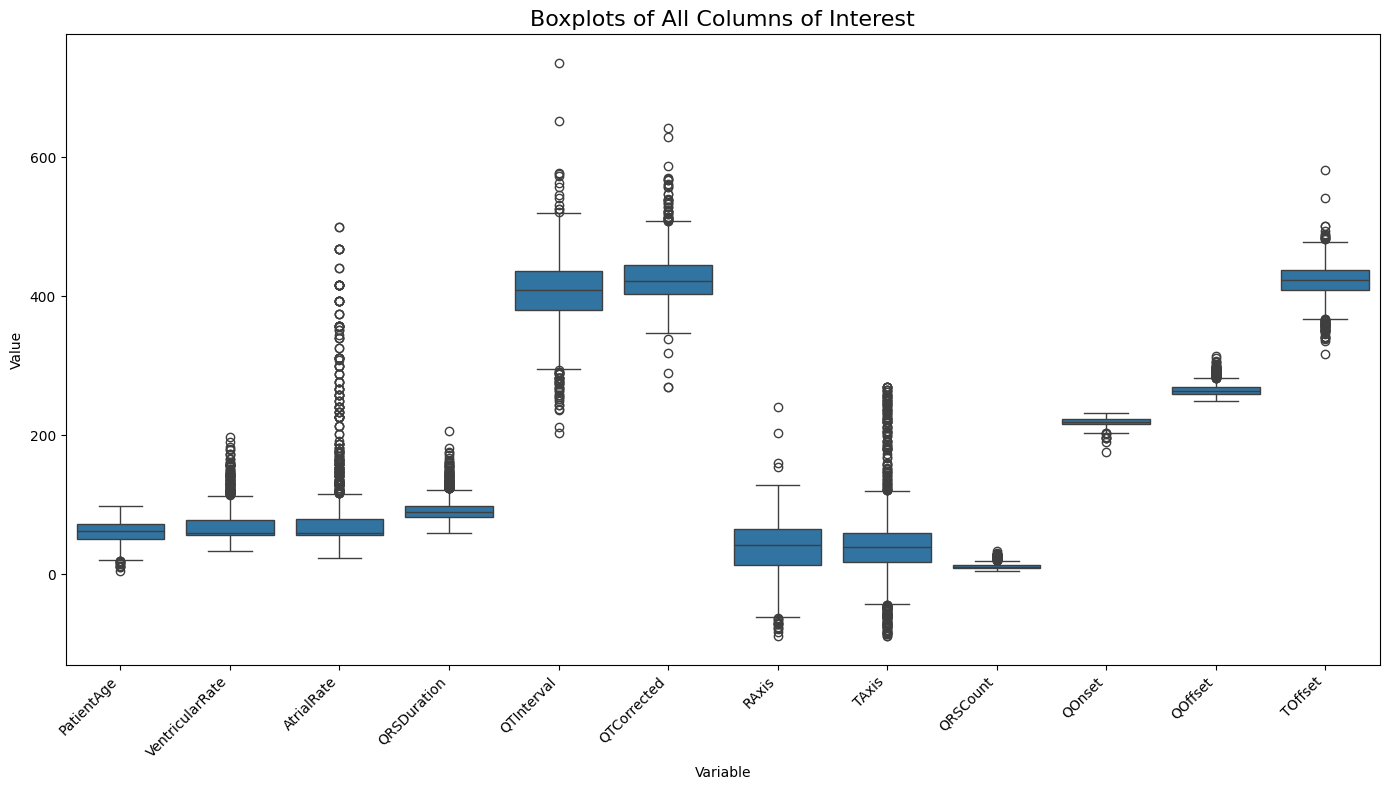

In [309]:
# Specify the columns of interest
columns_of_interest = [
    'PatientAge',
    'VentricularRate',
    'AtrialRate',
    'QRSDuration',
    'QTInterval',
    'QTCorrected',
    'RAxis',
    'TAxis',
    'QRSCount',
    'QOnset',
    'QOffset',
    'TOffset'
]

# Generate descriptive statistics for the selected columns
desc_stats = combined_df[columns_of_interest].describe()
desc_stats.loc['median'] = combined_df[columns_of_interest].median()
desc_stats = desc_stats.reindex(['min', 'max', 'mean', 'median', 'std'])
desc_stats = desc_stats.round(2)
print(desc_stats)

# Create boxplots for the columns

# Create a long-form DataFrame suitable for seaborn
df_melted = combined_df[columns_of_interest].melt(var_name='Variable', value_name='Value')

# Set the figure size
plt.figure(figsize=(14, 8))

# Create a boxplot with all the columns in one visualization
sns.boxplot(x='Variable', y='Value', data=df_melted)

# Set the title and adjust the layout
plt.title('Boxplots of All Columns of Interest', fontsize=16)
plt.xticks(rotation=45, ha='right')  # Rotate the x labels for better readability
plt.tight_layout()

# Display the plot
plt.show()


Next I want to compare the ECG leads for the different arrythmia types. The following visualization shows the various arrythmia types and the distribution of thei values and potential outliers:

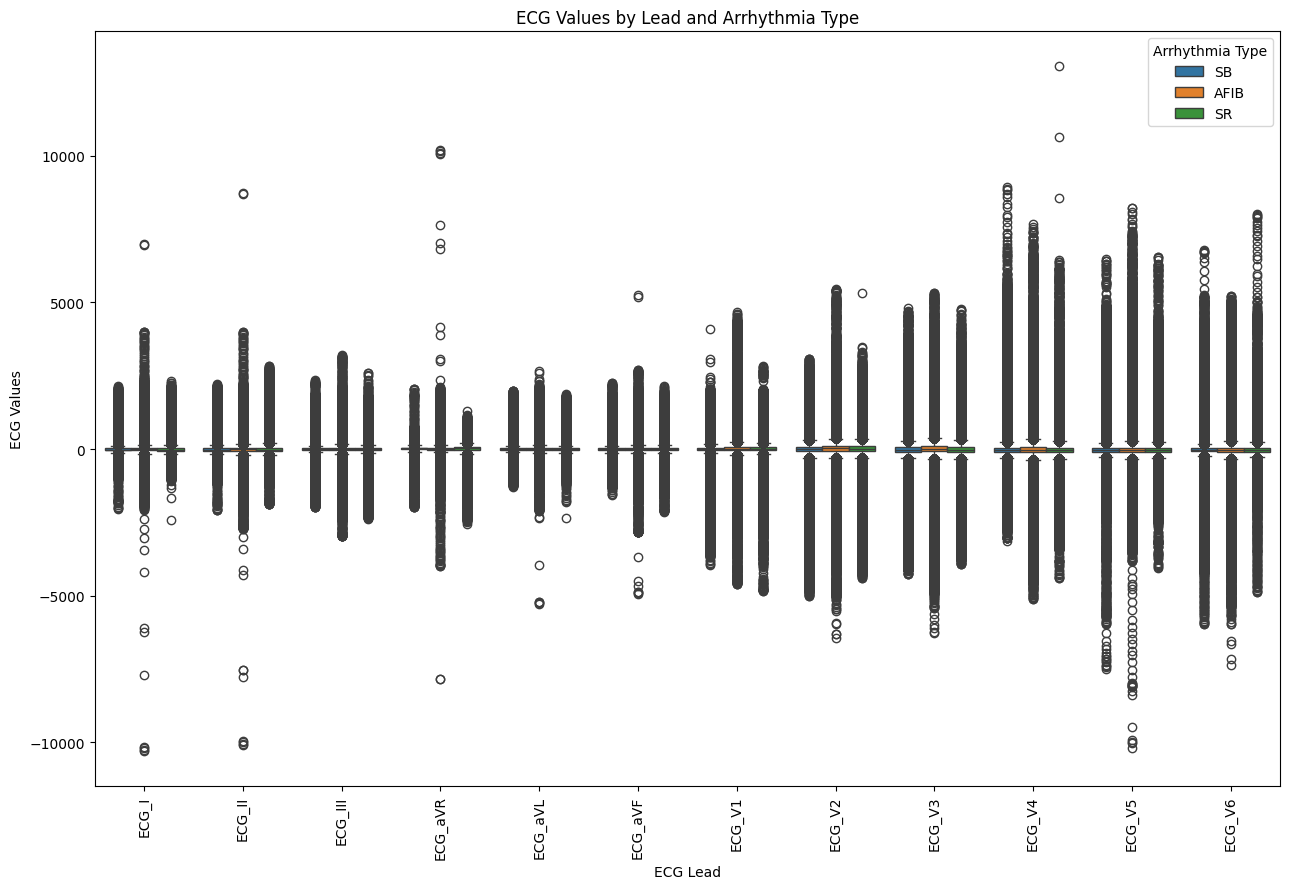

In [310]:
def plot_combined_ecg_boxplots(combined_df):
    # List of ECG columns
    ecg_leads = [col for col in combined_df.columns if col.startswith('ECG_')]
    
    ecg_data_combined = []
    
    for lead in ecg_leads:
        # Flatten the ECG data lists for each arrhythmia type
        for arrhythmia_type in ArrhythmiaTypes:
            data = combined_df[combined_df['Rhythm'] == arrhythmia_type.value][lead]
            if isinstance(data.iloc[0], list):  # Check if data is a list
                data = [item for sublist in data.dropna() for item in sublist]
            else:
                data = data.dropna()
            
            ecg_data_combined.append(pd.DataFrame({
                'ECG_Lead': lead,
                'Arrhythmia': arrhythmia_type.value,
                'ECG_Value': data
            }))
    
    # Combine all data into one DataFrame
    combined_df_ecg = pd.concat(ecg_data_combined)
    
    plt.figure(figsize=(13, 9))
    sns.boxplot(x='ECG_Lead', y='ECG_Value', hue='Arrhythmia', data=combined_df_ecg)
    
    plt.title('ECG Values by Lead and Arrhythmia Type')
    plt.xlabel('ECG Lead')
    plt.ylabel('ECG Values')
    plt.legend(title='Arrhythmia Type')
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    
    plt.tight_layout()
    plt.show()

# This takes too long for more patient data which is why I left it out of the analysis
plot_combined_ecg_boxplots(combined_df)

Now I want to have a closer look at each lead/channel:

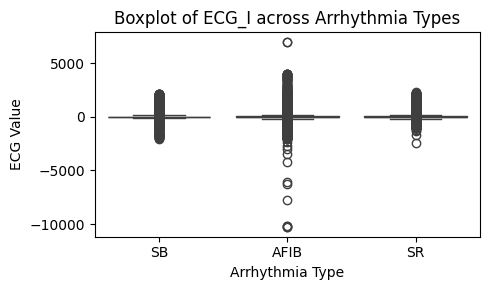

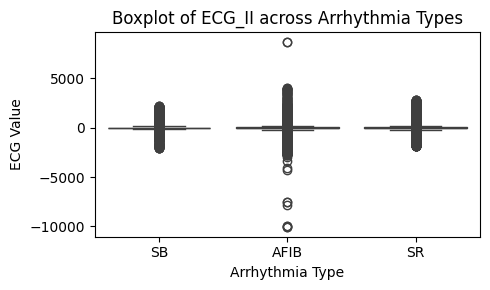

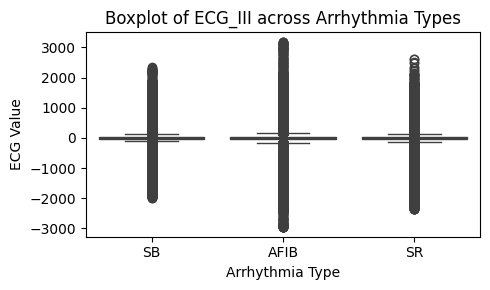

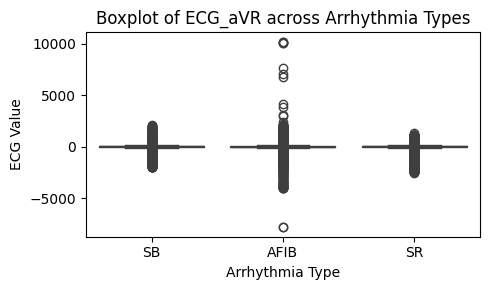

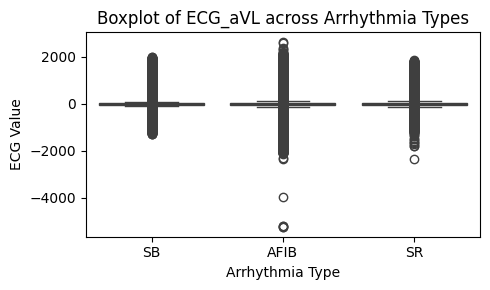

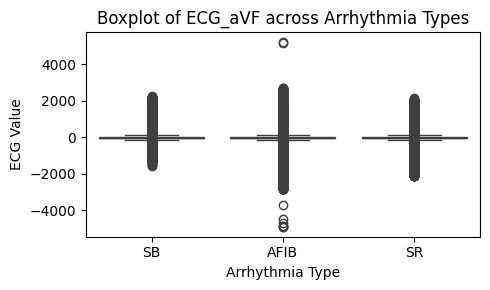

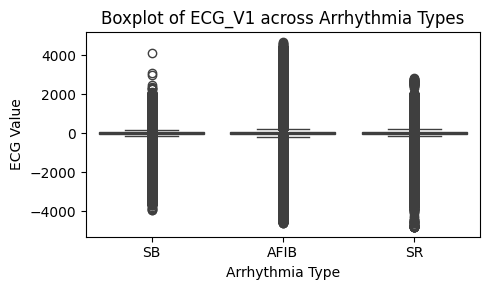

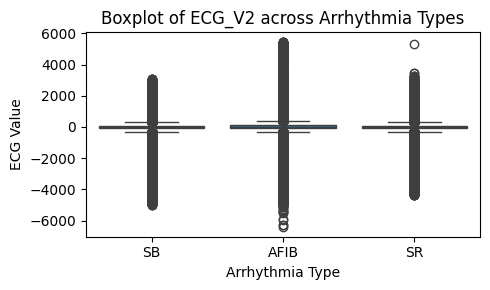

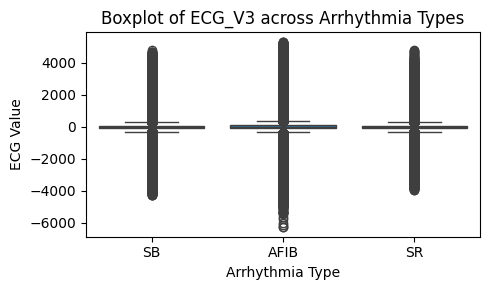

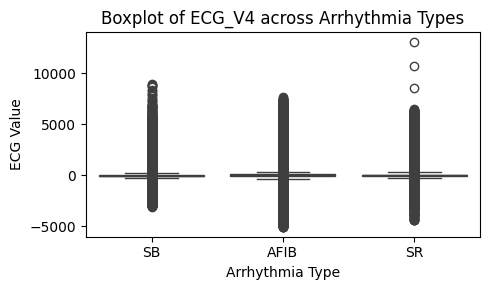

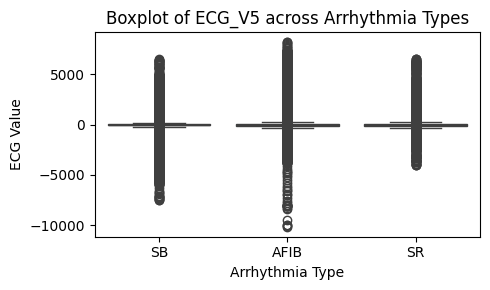

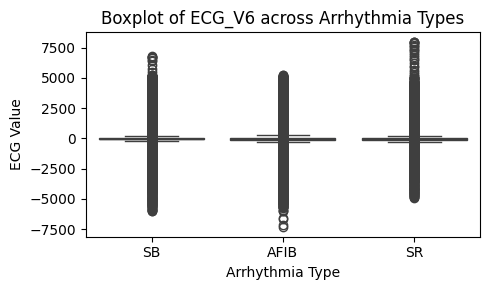

In [311]:
def compare_arrhythmias(combined_df):
    melted_data = []
    
    for arrhythmia_type in ArrhythmiaTypes:
        filtered_df = combined_df[combined_df['Rhythm'] == arrhythmia_type.value]
        
        for col in filtered_df.columns:
            if col.startswith('ECG_'):
                # For each ECG lead, concatenate the data and store it along with the arrhythmia type
                ecg_data = np.concatenate(filtered_df[col].dropna().values)
                for value in ecg_data:
                    melted_data.append({'ECG_Lead': col, 'ECG_Value': value, 'Arrhythmia': arrhythmia_type.value})
    
    # Convert to a DataFrame for visualization
    melted_df = pd.DataFrame(melted_data)
    
    ecg_leads = melted_df['ECG_Lead'].unique()
    
    # Plot the boxplots for each ECG lead
    for lead in ecg_leads:
        plt.figure(figsize=(5, 3))
        
        # Filter data for the current lead
        lead_data = melted_df[melted_df['ECG_Lead'] == lead]
        
        sns.boxplot(x='Arrhythmia', y='ECG_Value', data=lead_data)
        
        plt.title(f'Boxplot of {lead} across Arrhythmia Types')
        plt.ylabel('ECG Value')
        plt.xlabel('Arrhythmia Type')
        
        plt.tight_layout()
        plt.show()

compare_arrhythmias(combined_df)

Next I want to look at the variance of the ECG leads across the different arrythmia types:

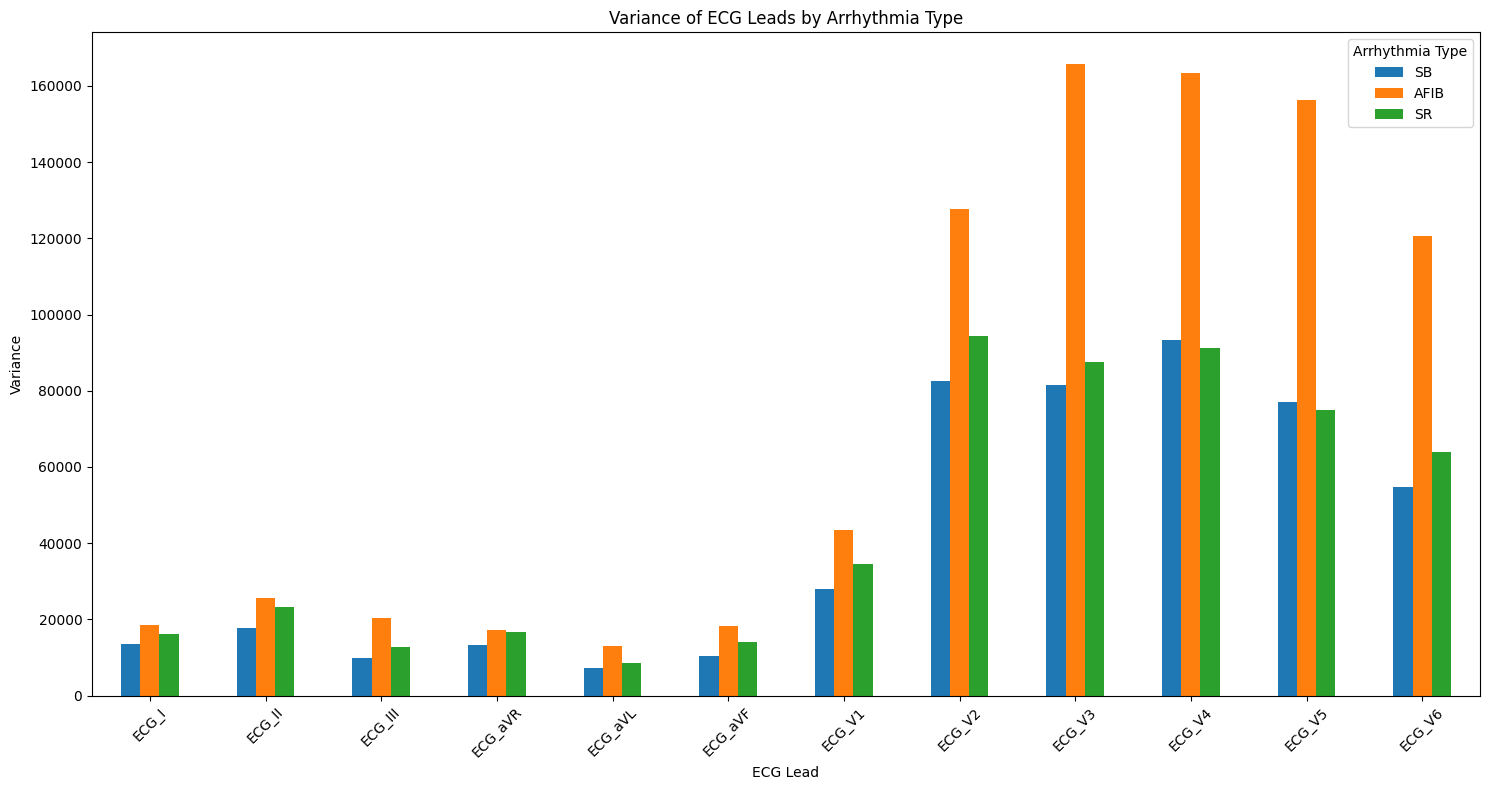

In [312]:
def calculate_variance(df, arrhythmia_type):
    filtered_df = df[df['Rhythm'] == arrhythmia_type.value]
    variances = {}
    for col in filtered_df.columns:
        if col.startswith('ECG_'):
            ecg_data = np.concatenate(filtered_df[col].dropna().values)
            variances[col] = np.var(ecg_data)
    return pd.Series(variances, name=arrhythmia_type.value)

def visualize_variances(combined_df):
    # Calculate variance for each arrhythmia type
    variance_dfs = []
    for arrhythmia_type in ArrhythmiaTypes:
        variance_series = calculate_variance(combined_df, arrhythmia_type)
        variance_dfs.append(variance_series)

    # Combine all variances into a single DataFrame
    variances_df = pd.concat(variance_dfs, axis=1)
    variances_df.columns = [arrhythmia_type.value for arrhythmia_type in ArrhythmiaTypes]
    
    variances_df.plot(kind='bar', figsize=(15, 8))
    plt.title('Variance of ECG Leads by Arrhythmia Type')
    plt.xlabel('ECG Lead')
    plt.ylabel('Variance')
    plt.xticks(rotation=45)
    plt.legend(title="Arrhythmia Type")
    plt.tight_layout()
    plt.show()

visualize_variances(combined_df)


## Data analysis

In this section I will prepare the data for the ML model.

### Data cleaning

First I will do some basic steps to clean the data (handling missing data values, removing outliers). Afterwards the ECG readings are normalized using Z-Score-normalization. Then butterworth filtering is applied to remove basline wandering and low-pass filtering is apllied to remove high-frequency noise.

In [313]:
def handle_missing_values(data):
    # Interpolate missing values
    if isinstance(data, (list, np.ndarray)):
        data = np.array(data)
        if np.isnan(data).any():
            nans, x = np.isnan(data), lambda z: z.nonzero()[0]
            data[nans] = np.interp(x(nans), x(~nans), data[~nans])
    elif pd.isna(data):
        return np.nan
    return data

def remove_outliers(data):
    # Remove outliers using IQR method
    if isinstance(data, (list, np.ndarray)):
        data = np.array(data)
        Q1 = np.percentile(data, 25)
        Q3 = np.percentile(data, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return np.clip(data, lower_bound, upper_bound)
    else:
        return data

def z_score_normalize(data):
    # Calculate mean and standard deviation
    if isinstance(data, (list, np.ndarray)):
        data = np.array(data)
        mean = np.mean(data)
        std = np.std(data)
        
        # Avoid division by zero
        if std == 0:
            return np.zeros_like(data)
        
        # Perform z-score normalization
        normalized_data = (data - mean) / std
        return normalized_data
    else:
        return data

def remove_baseline_wander(ecg_signal, sampling_rate):
    # Design a highpass filter
    nyquist_freq = 0.5 * sampling_rate
    cutoff = 0.5 / nyquist_freq
    b, a = signal.butter(1, cutoff, btype='high', analog=False)
    
    # Apply the filter
    return signal.filtfilt(b, a, ecg_signal)

def reduce_noise(ecg_signal, sampling_rate):
    # Design a lowpass filter
    nyquist_freq = 0.5 * sampling_rate
    cutoff = 50 / nyquist_freq
    b, a = signal.butter(6, cutoff, btype='low', analog=False)
    
    # Apply the filter
    return signal.filtfilt(b, a, ecg_signal)

def clean_ecg_signal(ecg_signal):
    # Sampling rate as defined in the paper
    sampling_rate = 500
    
    # Convert to numpy array
    ecg_signal = np.array(ecg_signal)
    
    # Handle missing values
    ecg_signal = handle_missing_values(ecg_signal)

    # Remove baseline wander
    ecg_signal = remove_baseline_wander(ecg_signal, sampling_rate)
    
    # Reduce high-frequency noise
    ecg_signal = reduce_noise(ecg_signal, sampling_rate)
    
    # Remove outliers
    ecg_signal = remove_outliers(ecg_signal)

    # Perform z-score normalization
    ecg_signal = z_score_normalize(ecg_signal)
    
    return ecg_signal

def clean_numeric_value(value):
    # Handle missing values
    value = handle_missing_values(value)
    
    # Remove outliers
    value = remove_outliers(value)
    
    return value

def normalize_numeric_column(column):
    return z_score_normalize(column)


In [314]:
def clean_data(combined_df):
    # Create a copy of the dataframe to avoid modifying the original
    cleaned_df = combined_df.copy()

    # Identify ECG columns
    ecg_columns = [col for col in cleaned_df.columns if col.startswith('ECG_')]
    
    if not ecg_columns:
        raise ValueError("No ECG columns found in the DataFrame.")
    
    # Identify numeric columns (excluding ECG columns)
    numeric_columns = cleaned_df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_columns = [col for col in numeric_columns if col not in ecg_columns]
    
    # Clean ECG data
    for col in ecg_columns:
        cleaned_df[col] = cleaned_df[col].apply(clean_ecg_signal)
    
    scaler = StandardScaler()
    cleaned_df[numeric_columns] = scaler.fit_transform(cleaned_df[numeric_columns])
    
    print("\nAfter normalization:")
    print(cleaned_df[numeric_columns].iloc[0])
    
    # Print sample of final cleaned data
    print("\nSample of final cleaned data:")
    print(cleaned_df.iloc[0])
    
    return cleaned_df

# Apply the cleaning function
cleaned_df = clean_data(combined_df)


After normalization:
PatientAge         0.304944
VentricularRate   -0.382103
AtrialRate        -0.333844
QRSDuration       -1.257677
QTInterval        -0.394972
QTCorrected       -1.056535
RAxis              0.085176
TAxis             -0.059519
QRSCount          -0.107652
QOnset             0.090661
QOffset           -1.169958
TOffset           -0.369588
Name: 0, dtype: float64

Sample of final cleaned data:
FileName                                  MUSE_20180209_170349_37000
Rhythm                                                            SR
Beat                                                            NONE
PatientAge                                                  0.304944
Gender                                                        FEMALE
VentricularRate                                            -0.382103
AtrialRate                                                 -0.333844
QRSDuration                                                -1.257677
QTInterval                         

### Feature Extraction


214 Features are extracted for the analysis:

In [315]:
def extract_statistical_features(ecg_series):
    return pd.Series({
        'mean': np.mean(ecg_series),
        'std': np.std(ecg_series),
        'skewness': stats.skew(ecg_series),
        'kurtosis': stats.kurtosis(ecg_series),
        'rms': np.sqrt(np.mean(np.square(ecg_series)))
    })

def extract_frequency_domain_features(ecg_series):
    f, psd = signal.welch(ecg_series, fs=250, nperseg=256)
    
    # Define frequency bands
    vlf, lf, hf = (0.003, 0.04), (0.04, 0.15), (0.15, 0.4)
    
    # Calculate power in each band
    vlf_power = np.trapezoid(psd[(f >= vlf[0]) & (f <= vlf[1])])
    lf_power = np.trapezoid(psd[(f >= lf[0]) & (f <= lf[1])])
    hf_power = np.trapezoid(psd[(f >= hf[0]) & (f <= hf[1])])
    total_power = vlf_power + lf_power + hf_power
    
    return pd.Series({
        'lf_hf_ratio': lf_power / hf_power if hf_power != 0 else 0,
        'lf_power_normalized': lf_power / total_power if total_power != 0 else 0,
        'hf_power_normalized': hf_power / total_power if total_power != 0 else 0
    })

def extract_wavelet_features(ecg_series):
    coeffs = pywt.wavedec(ecg_series, 'db4', level=4)
    return pd.Series({
        f'wavelet_energy_level_{i}': np.sum(np.square(coeff)) for i, coeff in enumerate(coeffs)
    })

def extract_morphological_features(ecg_series):
    # Detect R-peaks
    r_peaks, _ = signal.find_peaks(ecg_series, height=0.5*np.max(ecg_series), distance=50)
    
    # Calculate RR intervals
    rr_intervals = np.diff(r_peaks)
    
    return pd.Series({
        'mean_rr_interval': np.mean(rr_intervals),
        'std_rr_interval': np.std(rr_intervals),
        'pnn50': np.sum(np.abs(np.diff(rr_intervals)) > 50) / len(rr_intervals) * 100,
        'r_peak_amplitude': np.mean(ecg_series[r_peaks])
    })


In [316]:
def extract_features(df):
    ecg_columns = ['ECG_I', 'ECG_II', 'ECG_III', 'ECG_aVR', 'ECG_aVL', 'ECG_aVF', 'ECG_V1', 'ECG_V2', 'ECG_V3', 'ECG_V4', 'ECG_V5', 'ECG_V6']
    
    features = pd.DataFrame()
    
    for col in ecg_columns:
        time_features = df[col].apply(extract_statistical_features)
        freq_features = df[col].apply(extract_frequency_domain_features)
        wavelet_features = df[col].apply(extract_wavelet_features)
        morph_features = df[col].apply(extract_morphological_features)
        
        time_features.columns = [f'{col}_{feat}' for feat in time_features.columns]
        freq_features.columns = [f'{col}_{feat}' for feat in freq_features.columns]
        wavelet_features.columns = [f'{col}_{feat}' for feat in wavelet_features.columns]
        morph_features.columns = [f'{col}_{feat}' for feat in morph_features.columns]
        
        features = pd.concat([features, time_features, freq_features, wavelet_features, morph_features], axis=1)
    
    additional_columns = ['PatientAge', 'VentricularRate', 'AtrialRate', 'QRSDuration', 'QTInterval', 'QTCorrected', 'RAxis', 'TAxis', 'QRSCount']
    features = pd.concat([features, df[additional_columns]], axis=1)
    
    # Convert Gender to numeric
    features['Gender'] = (df['Gender'] == 'MALE').astype(int)
    
    return features

features = extract_features(cleaned_df)
print("Feature extraction complete.")
print(features.iloc[0])

Feature extraction complete.
ECG_I_mean        0.000000
ECG_I_std         1.000000
ECG_I_skewness    0.678855
ECG_I_kurtosis   -0.008046
ECG_I_rms         1.000000
                    ...   
QTCorrected      -1.056535
RAxis             0.085176
TAxis            -0.059519
QRSCount         -0.107652
Gender            0.000000
Name: 0, Length: 214, dtype: float64


Now I will check for redundant or highly correlated features:

In [317]:
def analyze_correlations(features, threshold=0.8):
    # Compute the correlation matrix
    corr_matrix = features.corr().abs()

    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # Find feature pairs with correlation greater than the threshold
    high_corr_pairs = [(corr_matrix.index[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])
                       for i in range(len(corr_matrix.index))
                       for j in range(i+1, len(corr_matrix.columns))
                       if corr_matrix.iloc[i, j] > threshold]

def remove_correlated_features(features, threshold=0.8):
    corr_matrix = features.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    print(f"Removing {len(to_drop)} features due to high correlation:")
    print(to_drop)
    
    return features.drop(columns=to_drop)

high_corr_pairs = analyze_correlations(features, threshold=0.8)
reduced_features = remove_correlated_features(features, threshold=0.8)
features = reduced_features

print(f"Original feature count: {features.shape[1]}")
print(f"Reduced feature count: {reduced_features.shape[1]}")

print(features.iloc[0])

Removing 40 features due to high correlation:
['ECG_I_rms', 'ECG_I_wavelet_energy_level_1', 'ECG_I_wavelet_energy_level_2', 'ECG_II_rms', 'ECG_II_wavelet_energy_level_1', 'ECG_II_wavelet_energy_level_3', 'ECG_III_rms', 'ECG_III_wavelet_energy_level_1', 'ECG_III_wavelet_energy_level_2', 'ECG_aVR_skewness', 'ECG_aVR_rms', 'ECG_aVR_wavelet_energy_level_0', 'ECG_aVR_wavelet_energy_level_1', 'ECG_aVR_wavelet_energy_level_2', 'ECG_aVL_rms', 'ECG_aVL_wavelet_energy_level_1', 'ECG_aVL_wavelet_energy_level_2', 'ECG_aVF_skewness', 'ECG_aVF_rms', 'ECG_aVF_wavelet_energy_level_1', 'ECG_aVF_wavelet_energy_level_3', 'ECG_aVF_std_rr_interval', 'ECG_V1_rms', 'ECG_V1_wavelet_energy_level_1', 'ECG_V2_rms', 'ECG_V2_wavelet_energy_level_1', 'ECG_V3_rms', 'ECG_V3_wavelet_energy_level_1', 'ECG_V3_std_rr_interval', 'ECG_V4_rms', 'ECG_V4_wavelet_energy_level_1', 'ECG_V5_rms', 'ECG_V5_wavelet_energy_level_0', 'ECG_V5_wavelet_energy_level_1', 'ECG_V5_std_rr_interval', 'ECG_V6_rms', 'ECG_V6_wavelet_energy_level_

### Machine Learning

First of all I will use a simple model to adress the research question: Logistic regression. I will also analyse the model performance. Afterwards I want to have a closer look at the model and its decision so I will apply SHAP and feature importance.

In [342]:
# Create target variable
y = cleaned_df['Rhythm'].map({'SR': 0, 'SB': 1, 'AFIB': 2})

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Multiclass Logistic Regression model
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

# Make predictions
y_pred = log_reg.predict(X_test_scaled)
y_pred_proba = log_reg.predict_proba(X_test_scaled)

Analysis of the Logistic Regression models performance (all 172 features):

Classification Report:
              precision    recall  f1-score   support

          SR       0.88      0.91      0.89       108
          SB       0.94      0.96      0.95       209
        AFIB       0.91      0.84      0.88       102

    accuracy                           0.92       419
   macro avg       0.91      0.90      0.91       419
weighted avg       0.92      0.92      0.92       419



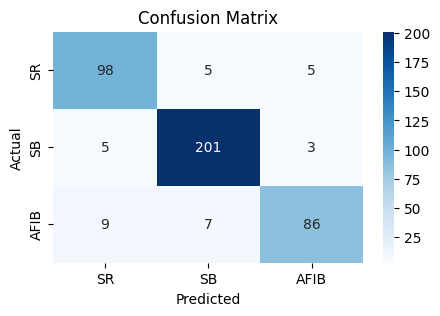

In [343]:
# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['SR', 'SB', 'AFIB']))

# Visualize the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['SR', 'SB', 'AFIB'], yticklabels=['SR', 'SB', 'AFIB'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


Now I want to identify the Top 20 features using a combined score of SHAP values und feature importance:

In [344]:
def get_feature_importance(log_reg_model, feature_names):
    # For logistic regression, we'll use the absolute values of coefficients
    importance = np.abs(log_reg_model.coef_).mean(axis=0)  # Mean across classes for multi-class
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False)
    
    return importance_df

def analyze_shap_values(log_reg_model, X, feature_names):
    explainer = shap.LinearExplainer(log_reg_model, X)
    shap_values = explainer.shap_values(X)
    
    # Check the shape of shap_values
    if isinstance(shap_values, list):
        # Average across classes
        mean_shap = np.mean([np.abs(sv).mean(axis=0) for sv in shap_values], axis=0)
    else:
        # Average across samples
        mean_shap = np.abs(shap_values).mean(axis=0)
    
    # Further aggregate mean_shap across classes to get a single value per feature
    if mean_shap.ndim == 2:
        mean_shap = mean_shap.mean(axis=1)  # Average across classes
    
    return pd.DataFrame({
        'feature': feature_names,
        'shap_importance': mean_shap
    }).sort_values('shap_importance', ascending=False), shap_values

def combine_feature_importance(log_reg_model, X, shap_values, feature_names, n_top_features=30):
    # Get feature importance from Logistic Regression
    feature_importance_df = get_feature_importance(log_reg_model, feature_names)
    
    # Calculate mean absolute SHAP values for each feature
    if isinstance(shap_values, list):
        mean_shap = np.mean([np.abs(sv).mean(axis=0) for sv in shap_values], axis=0)
    else:
        mean_shap = np.abs(shap_values).mean(axis=0)
    
    # Further aggregate mean_shap across classes to get a single value per feature
    if mean_shap.ndim == 2:
        mean_shap = mean_shap.mean(axis=1)  # Average across classes
    
    # Add SHAP values to the DataFrame
    feature_importance_df['shap_importance'] = mean_shap
    
    # Normalize both importance measures
    feature_importance_df['importance_normalized'] = feature_importance_df['importance'] / feature_importance_df['importance'].sum()
    feature_importance_df['shap_importance_normalized'] = feature_importance_df['shap_importance'] / feature_importance_df['shap_importance'].sum()
    
    # Calculate combined importance 
    feature_importance_df['combined_importance'] = (
        feature_importance_df['importance_normalized'] + 
        feature_importance_df['shap_importance_normalized']
    ) / 2
    
    # Sort by combined importance
    feature_importance_df = feature_importance_df.sort_values('combined_importance', ascending=False)
    
    return feature_importance_df.head(n_top_features)

def plot_combined_importance(combined_importance):
    plt.figure(figsize=(6, 4))
    sns.barplot(x='combined_importance', y='feature', data=combined_importance)
    plt.title('Top Features: Combined Importance (Logistic Regression + SHAP)')
    plt.xlabel('Combined Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

                           feature  importance  shap_importance  \
143             ECG_V5_lf_hf_ratio    0.000000     2.160359e+00   
169                     QTInterval    2.680586     4.591994e-02   
33     ECG_III_lf_power_normalized    0.000000     1.855473e+00   
166                VentricularRate    2.264951     4.879227e-33   
170                    QTCorrected    1.214788     3.948950e-01   
167                     AtrialRate    1.160081     2.568802e-01   
116     ECG_V3_hf_power_normalized    0.000000     9.200681e-01   
50        ECG_aVR_mean_rr_interval    0.576640     4.092926e-01   
137                   ECG_V4_pnn50    0.343041     4.933199e-01   
2                   ECG_I_skewness    0.472781     3.927413e-01   
141                ECG_V5_skewness    0.162294     6.084605e-01   
92          ECG_V1_std_rr_interval    0.194326     5.474298e-01   
32             ECG_III_lf_hf_ratio    0.000000     6.862327e-01   
105  ECG_V2_wavelet_energy_level_4    0.257942     4.452595e-0

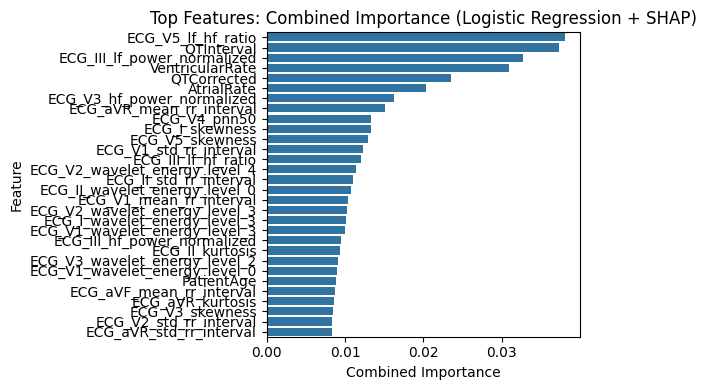


Top 20 features:
1. ECG_V5_lf_hf_ratio
2. QTInterval
3. ECG_III_lf_power_normalized
4. VentricularRate
5. QTCorrected
6. AtrialRate
7. ECG_V3_hf_power_normalized
8. ECG_aVR_mean_rr_interval
9. ECG_V4_pnn50
10. ECG_I_skewness
11. ECG_V5_skewness
12. ECG_V1_std_rr_interval
13. ECG_III_lf_hf_ratio
14. ECG_V2_wavelet_energy_level_4
15. ECG_II_std_rr_interval
16. ECG_II_wavelet_energy_level_0
17. ECG_V1_mean_rr_interval
18. ECG_V2_wavelet_energy_level_3
19. ECG_I_wavelet_energy_level_3
20. ECG_V1_wavelet_energy_level_3
21. ECG_III_hf_power_normalized
22. ECG_II_kurtosis
23. ECG_V3_wavelet_energy_level_2
24. ECG_V1_wavelet_energy_level_0
25. PatientAge
26. ECG_aVF_mean_rr_interval
27. ECG_aVR_kurtosis
28. ECG_V3_skewness
29. ECG_V2_std_rr_interval
30. ECG_aVR_std_rr_interval


In [345]:
feature_names = features.columns

# Analyze SHAP values
shap_df, shap_values = analyze_shap_values(log_reg, X_test_scaled, feature_names)

# Combine feature importance
combined_importance = combine_feature_importance(log_reg, X_test_scaled, shap_values, feature_names)
print(combined_importance)
plot_combined_importance(combined_importance)

# Get top 20 features
top_features = combined_importance['feature'].tolist()

print("\nTop 20 features:")
for i, feature in enumerate(top_features, 1):
    print(f"{i}. {feature}")



Re-training of the Logistic Regression model using only the Top 20 features:


Classification Report with Top 20 Features:
              precision    recall  f1-score   support

          SR       0.87      0.90      0.88       108
          SB       0.95      0.98      0.96       209
        AFIB       0.89      0.79      0.84       102

    accuracy                           0.91       419
   macro avg       0.90      0.89      0.90       419
weighted avg       0.91      0.91      0.91       419



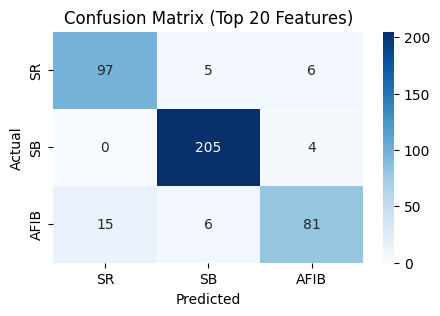

In [346]:
X_top = features[top_features]
X_train, X_test, y_train, y_test = train_test_split(X_top, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

y_pred = log_reg.predict(X_test_scaled)

print("\nClassification Report with Top 20 Features:")
print(classification_report(y_test, y_pred, target_names=['SR', 'SB', 'AFIB']))

# Visualize the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['SR', 'SB', 'AFIB'], yticklabels=['SR', 'SB', 'AFIB'])
plt.title('Confusion Matrix (Top 20 Features)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Apply Resampling:


Classification Report with Resampling:
              precision    recall  f1-score   support

          SR       0.89      0.91      0.90       108
          SB       0.95      0.98      0.97       209
        AFIB       0.89      0.82      0.86       102

    accuracy                           0.92       419
   macro avg       0.91      0.90      0.91       419
weighted avg       0.92      0.92      0.92       419



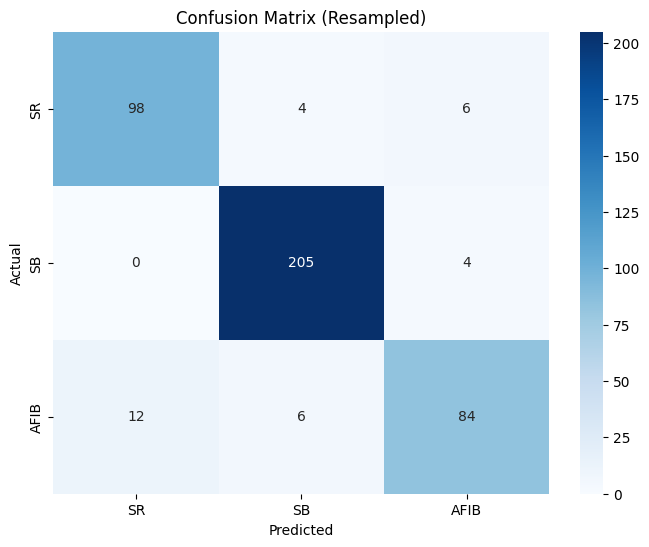


Original class distribution:
Rhythm
1    0.512239
0    0.260896
2    0.226866
Name: proportion, dtype: float64

Resampled class distribution:
Rhythm
0    0.333333
1    0.333333
2    0.333333
Name: proportion, dtype: float64


In [347]:
# Split the data
X_top = features[top_features]
X_train, X_test, y_train, y_test = train_test_split(X_top, y, test_size=0.2, random_state=42)

# Create a pipeline with SMOTE, RandomUnderSampler, StandardScaler, and LogisticRegression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('over', SMOTE(sampling_strategy='auto', random_state=42)),
    ('under', RandomUnderSampler(sampling_strategy='auto', random_state=42)),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Print classification report
print("\nClassification Report with Resampling:")
print(classification_report(y_test, y_pred, target_names=['SR', 'SB', 'AFIB']))

# Visualize the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['SR', 'SB', 'AFIB'], 
            yticklabels=['SR', 'SB', 'AFIB'])
plt.title('Confusion Matrix (Resampled)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print("\nOriginal class distribution:")
print(y_train.value_counts(normalize=True))

# Get resampled data
X_resampled, y_resampled = pipeline.named_steps['under'].fit_resample(
    pipeline.named_steps['over'].fit_resample(
        pipeline.named_steps['scaler'].fit_transform(X_train),
        y_train
    )[0],
    y_train
)

print("\nResampled class distribution:")
print(pd.Series(y_resampled).value_counts(normalize=True))

Next I will use a more complex model to adress the reserach question: Random Forest. I will also analyse this models performance. Afterwards the SHAP model is applied to better understand the decision-making process of the model:

In [348]:
# Create target variable
y = cleaned_df['Rhythm'].map({ArrhythmiaTypes.SB.value: 0, ArrhythmiaTypes.AFIB.value: 1, ArrhythmiaTypes.SR.value: 2})

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_scaled)

Performance analysis of the Random Forest model (using all 172 features):

              precision    recall  f1-score   support

          SB       0.97      1.00      0.98       209
        AFIB       0.95      0.84      0.89       102
          SR       0.92      0.95      0.94       108

    accuracy                           0.95       419
   macro avg       0.94      0.93      0.94       419
weighted avg       0.95      0.95      0.95       419



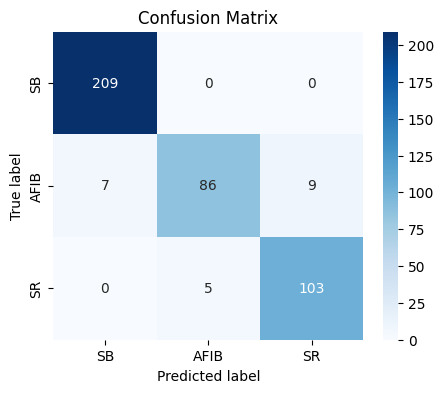

In [349]:
print(classification_report(y_test, y_pred, target_names=[t.value for t in ArrhythmiaTypes]))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[t.value for t in ArrhythmiaTypes], 
            yticklabels=[t.value for t in ArrhythmiaTypes])
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Now I want to find the most important features for the prediction:

In [350]:
def get_feature_importance(rf_model, X, feature_names):
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    return importance_df

def analyze_shap_values(rf_model, X, feature_names):
    explainer = shap.TreeExplainer(rf_model)
    shap_values = explainer.shap_values(X_test_scaled)
    
    # Reshape SHAP values
    shap_values = [np.swapaxes(sv, 0, 1) for sv in shap_values]
    
    # For multi-class: mean of absolute SHAP values across all classes
    mean_shap = np.mean([np.abs(sv).mean(axis=0) for sv in shap_values], axis=0)
    
    return pd.DataFrame({
        'feature': feature_names,
        'shap_importance': mean_shap
    }).sort_values('shap_importance', ascending=False), shap_values

def combine_feature_importance(rf_model, X, shap_values, feature_names, n_top_features=20):
    # Get feature importance from Random Forest
    feature_importance = rf_model.feature_importances_
    
    # Create DataFrame for feature importance
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'rf_importance': feature_importance
    })
    
    # Calculate mean absolute SHAP values for each feature
    mean_shap = np.mean([np.abs(sv).mean(axis=0) for sv in shap_values], axis=0)
    
    # Add SHAP values to the DataFrame
    feature_importance_df['shap_importance'] = mean_shap
    
    # Normalize both importance measures
    feature_importance_df['rf_importance_normalized'] = feature_importance_df['rf_importance'] / feature_importance_df['rf_importance'].sum()
    feature_importance_df['shap_importance_normalized'] = feature_importance_df['shap_importance'] / feature_importance_df['shap_importance'].sum()
    
    # Calculate combined importance 
    feature_importance_df['combined_importance'] = (
        feature_importance_df['rf_importance_normalized'] + 
        feature_importance_df['shap_importance_normalized']
    ) / 2
    
    # Sort by combined importance
    feature_importance_df = feature_importance_df.sort_values('combined_importance', ascending=False)
    
    return feature_importance_df.head(n_top_features)

def plot_combined_importance(combined_importance):
    plt.figure(figsize=(6, 4))
    sns.barplot(x='combined_importance', y='feature', data=combined_importance)
    plt.title('Top Features: Combined Importance (RF + SHAP)')
    plt.xlabel('Combined Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

                     feature  rf_importance  shap_importance  \
167               AtrialRate       0.147879         0.079578   
166          VentricularRate       0.127800         0.087833   
122             ECG_V3_pnn50       0.036837         0.018588   
137             ECG_V4_pnn50       0.032995         0.017649   
169               QTInterval       0.032605         0.017822   
107   ECG_V2_std_rr_interval       0.032761         0.017575   
136   ECG_V4_std_rr_interval       0.032024         0.015900   
150             ECG_V5_pnn50       0.026939         0.014397   
163             ECG_V6_pnn50       0.026767         0.013372   
121  ECG_V3_mean_rr_interval       0.025920         0.012868   
26              ECG_II_pnn50       0.022227         0.014174   
108             ECG_V2_pnn50       0.026022         0.011297   
135  ECG_V4_mean_rr_interval       0.022953         0.011290   
12               ECG_I_pnn50       0.020237         0.012687   
25    ECG_II_std_rr_interval       0.021

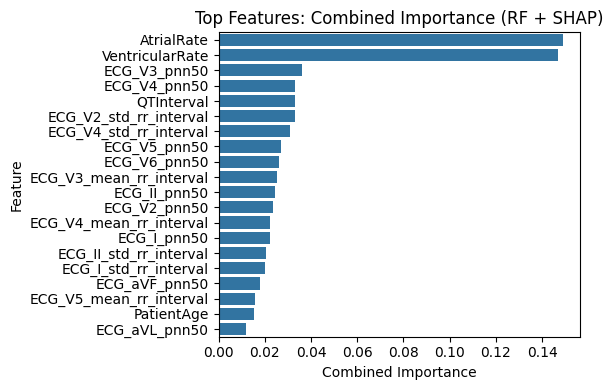

In [351]:
feature_names = features.columns

importance_df = get_feature_importance(rf_model, X_test_scaled, feature_names)
shap_df, shap_values = analyze_shap_values(rf_model, X_test_scaled, feature_names)

combined_importance = combine_feature_importance(rf_model, X_test_scaled, shap_values, feature_names)
print(combined_importance)
plot_combined_importance(combined_importance)

Re-training of the model using the 20 features:

In [352]:
top_20_features = combined_importance['feature'].head(20).tolist()

# Filter the original features to only include the top 20
X_top_20_train = X_train[top_20_features]
X_top_20_test = X_test[top_20_features]

X_top_20_train_scaled = scaler.fit_transform(X_top_20_train)
X_top_20_test_scaled = scaler.transform(X_top_20_test)

# Train the Random Forest model using the top 20 features
rf_model_top_20 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_top_20.fit(X_top_20_train_scaled, y_train)

# Make predictions with the new model
y_pred_top_20 = rf_model_top_20.predict(X_top_20_test_scaled)

In [353]:
accuracy = accuracy_score(y_test, y_pred_top_20)
report = classification_report(y_test, y_pred_top_20, target_names=[t.value for t in ArrhythmiaTypes])

print(f"Accuracy with top 20 features: {accuracy:.4f}")
print("Classification Report:")
print(report)


Accuracy with top 20 features: 0.9499
Classification Report:
              precision    recall  f1-score   support

          SB       0.97      1.00      0.98       209
        AFIB       0.94      0.85      0.89       102
          SR       0.93      0.94      0.94       108

    accuracy                           0.95       419
   macro avg       0.94      0.93      0.94       419
weighted avg       0.95      0.95      0.95       419



Stratified 5-fold Cross Validation for the Random Forest model:

In [354]:
def perform_cross_validation(features, y, combined_importance, n_splits=5):
    # Initialize variables to store results
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    all_y_true = []
    all_y_pred = []
    
    train_accuracies = []
    val_accuracies = []

    # Perform k-fold cross-validation
    for fold, (train_index, val_index) in enumerate(skf.split(features, y), 1):
        print(f"Fold {fold}")

        # Split the data
        X_train, X_val = features.iloc[train_index], features.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Filter features to include only top 20
        X_train_top_20 = X_train[top_20_features]
        X_val_top_20 = X_val[top_20_features]

        # Scale the features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_top_20)
        X_val_scaled = scaler.transform(X_val_top_20)

        # Train Random Forest model
        rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
        rf_model.fit(X_train_scaled, y_train)

        # Make predictions
        y_train_pred = rf_model.predict(X_train_scaled)
        y_val_pred = rf_model.predict(X_val_scaled)

        # Store true and predicted values for validation
        all_y_true.extend(y_val)
        all_y_pred.extend(y_val_pred)

        # Calculate accuracy for training and validation sets
        train_accuracy = accuracy_score(y_train, y_train_pred)
        val_accuracy = accuracy_score(y_val, y_val_pred)

        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print("Validation Classification Report:")
        print(classification_report(y_val, y_val_pred, target_names=[t.value for t in ArrhythmiaTypes]))
        print("\n")

    print("Average Training Accuracy:", np.mean(train_accuracies))
    print("Average Validation Accuracy:", np.mean(val_accuracies))

    return all_y_true, all_y_pred, train_accuracies, val_accuracies

def plot_confusion_matrix(all_y_true, all_y_pred):
    print("Overall Classification Report:")
    print(classification_report(all_y_true, all_y_pred, target_names=[t.value for t in ArrhythmiaTypes]))

    # Visualize the overall confusion matrix
    cm = confusion_matrix(all_y_true, all_y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=[t.value for t in ArrhythmiaTypes], 
                yticklabels=[t.value for t in ArrhythmiaTypes])
    plt.title('Overall Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def plot_accuracy_comparison(train_accuracies, val_accuracies):
    plt.figure(figsize=(5, 3))
    plt.plot(train_accuracies, label='Training Accuracy', marker='o')
    plt.plot(val_accuracies, label='Validation Accuracy', marker='o')
    plt.title('Training vs. Validation Accuracy per Fold')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


Fold 1
Validation Classification Report:
              precision    recall  f1-score   support

          SB       0.99      1.00      1.00       214
        AFIB       0.93      0.95      0.94        96
          SR       0.96      0.93      0.94       109

    accuracy                           0.97       419
   macro avg       0.96      0.96      0.96       419
weighted avg       0.97      0.97      0.97       419



Fold 2
Validation Classification Report:
              precision    recall  f1-score   support

          SB       0.98      1.00      0.99       214
        AFIB       0.93      0.91      0.92        96
          SR       0.95      0.94      0.94       109

    accuracy                           0.96       419
   macro avg       0.95      0.95      0.95       419
weighted avg       0.96      0.96      0.96       419



Fold 3
Validation Classification Report:
              precision    recall  f1-score   support

          SB       0.99      1.00      0.99       213
  

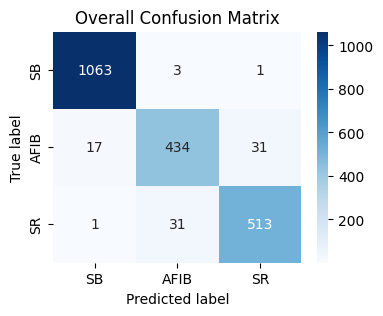

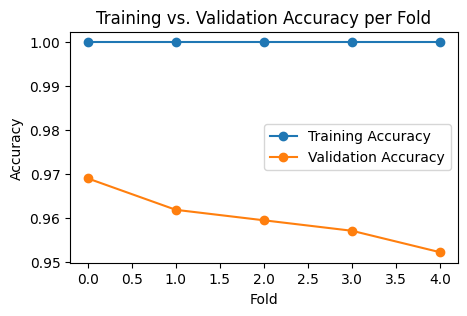

In [355]:
# Target variable
y = cleaned_df['Rhythm'].map({ArrhythmiaTypes.SB.value: 0, ArrhythmiaTypes.AFIB.value: 1, ArrhythmiaTypes.SR.value: 2})

# Perform cross-validation
all_y_true, all_y_pred, train_accuracies, val_accuracies = perform_cross_validation(features, y, combined_importance)

# Plot confusion matrix
plot_confusion_matrix(all_y_true, all_y_pred)

# Plot accuracy comparison
plot_accuracy_comparison(train_accuracies, val_accuracies)
